In [1]:
from mindquantum.device import QubitNode, QubitsTopology
from mindquantum.io import draw_topology

[WARNING] ME(4446:140186322552064,MainProcess):2023-12-03-00:02:01.511.581 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


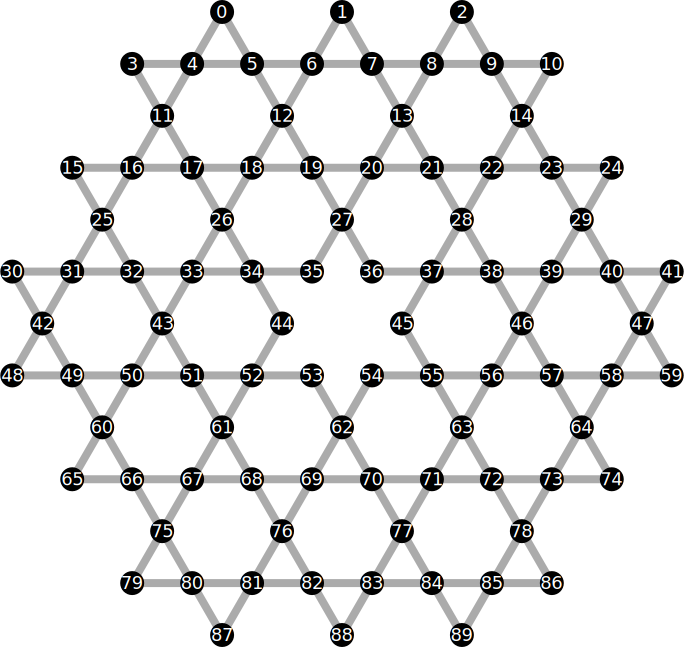

In [2]:
from typing import List, Union, Callable


class TopoEditor:
    def __init__(self, topo: QubitsTopology):
        self.selected: List[QubitNode] = []
        self.topo = topo

    def top(self):
        if not self.selected:
            return None
        return min(i.poi_y for i in self.selected)

    def bottom(self):
        if not self.selected:
            return None
        return max(i.poi_y for i in self.selected)

    def left(self):
        if not self.selected:
            return None
        return min(i.poi_x for i in self.selected)

    def right(self):
        if not self.selected:
            return None
        return max(i.poi_x for i in self.selected)

    def clean_selected(self):
        self.selected = []
        return self

    def select(self, qids: List[Union[int, QubitNode]], append: bool = False):
        if not append:
            self.clean_selected()
        if isinstance(qids, (int, QubitNode)):
            qids = [qids]
        for i in qids:
            if isinstance(i, QubitNode):
                self.selected.append(i)
            else:
                self.selected.append(self.topo[i])
        return self

    def select_with(self, callback: Callable[[QubitNode], bool], append: bool = False):
        if not append:
            self.clean_selected()
        for i in self.topo.qubits.values():
            if callback(i):
                self.selected.append(i)
        return self

    def select_range(self, start: int, stop: int, append: bool = False):
        return self.select_with(lambda i: start <= i.qubit_id < stop, append)

    def select_all(self):
        return self.select_with(lambda _: True, True)

    def shift(self, x, y):
        for i in self.selected:
            i.set_poi(i.poi_x + x, i.poi_y + y)
        return self

    def top_align(self):
        if len(self.selected) < 2:
            return self
        top = self.top()
        for i in self.selected:
            i.set_poi(i.poi_x, top)
        return self

    def bottom_align(self):
        if len(self.selected) < 2:
            return self
        bottom = self.bottom()
        for i in self.selected:
            i.set_poi(i.poi_x, bottom)
        return self

    def left_align(self):
        if len(self.selected) < 2:
            return self
        left = self.left()
        for i in self.selected:
            i.set_poi(left, i.poi_y)
        return self

    def right_align(self):
        if len(self.selected) < 2:
            return self
        right = self.right()
        for i in self.selected:
            i.set_poi(right, i.poi_y)
        return self

    def h_expand(self, dist: int = 1):
        if len(self.selected) < 2:
            return self
        sorted_qubit_node = sorted(self.selected, key=lambda x: x.poi_x)
        curr_x = sorted_qubit_node[0].poi_x
        for i in sorted_qubit_node[1:]:
            curr_x += dist
            i.set_poi(curr_x, i.poi_y)
        return self

    def __calc_distance__(self, i: QubitNode, j: QubitNode, round=6):
        v1 = np.array([i.poi_x, i.poi_y])
        v2 = np.array([j.poi_x, j.poi_y])
        return np.round(((v1 - v2) ** 2).sum(), round)

    def disconnect_all(self):
        if len(self.selected) < 2:
            return self
        for i in self.selected:
            for j in self.selected:
                if i.qubit_id <= j.qubit_id:
                    continue
                i < j
        return self

    def connect_neighbor(self):
        if len(self.selected) < 2:
            return self
        for i in self.selected:
            dist = []
            min_d = np.inf
            for j in self.selected:
                if i.qubit_id==j.qubit_id :
                    continue
                d = self.__calc_distance__(i, j)
                dist.append((d, j))
                min_d = min(min_d, d)
            for j in dist:
                if j[0] == min_d:
                    i >> j[1]
        return self


# all_node = [QubitNode(i) for i in range(20)]
# topo = QubitsTopology(all_node)

# te = TopoEditor(topo)
# te.select_range(0, 5).h_expand()
# te.select_range(5, 10).shift(0, 2)
# te.select_range(10, 15).shift(0, 3)
# te.select_range(15, 20).shift(0, 4)
# te.select_with(lambda i: i.qubit_id%5==1).shift(1, 0)
# te.select_with(lambda i: i.qubit_id%5==2).shift(2, 0)
# te.select_with(lambda i: i.qubit_id%5==3).shift(3, 0)
# te.select_with(lambda i: i.qubit_id%5==4).shift(4, 0)
# te.select_range(1, 5).shift(0, -1)
# te.select_with(lambda i:i.qubit_id%6==0).top_align()
# te.select([11, 16]).shift(0, 4)
# te.select([1, 17, 8]).bottom_align()
# te.select([6, 7]).left_align()
# te.select([5, 12]).right_align()
# draw_topology(topo)

import numpy as np


class Kagome:
    def __init__(self, n_layer: int = 1):
        self.n_layer = n_layer
        self.n_long = list(range(self.n_layer, self.n_layer * 2 + 1))
        self.n_long = self.n_long + self.n_long[-2::-1]
        self.n_short = list(range(2 * (self.n_layer + 1), 4 * self.n_layer + 1, 2))
        self.n_short = self.n_short + self.n_short[::-1]
        self.n_qubits = sum(self.n_long + self.n_short)
        self.topo = QubitsTopology([QubitNode(i) for i in range(self.n_qubits)])
        self.place_qubits()
        TopoEditor(self.topo).select_all().connect_neighbor()

    def place_qubits(self):
        current_id = 0
        end_id = 0
        te = TopoEditor(self.topo)
        poi_x, poi_y = 0, 0
        n_line = len(self.n_long) + len(self.n_short)
        for i in range(n_line):
            current_id = end_id
            end_id, dis = current_id + (self.n_short if i & 1 else self.n_long)[i // 2], (1 if i & 1 else 2)
            te.select_range(current_id, end_id).h_expand(dis).shift(poi_x, poi_y)
            if i < n_line // 2:
                poi_x += 0.5 * (i & 1) - 1.5 * (i & 1 == 0)
            else:
                poi_x += 1.5 * (i & 1) - 0.5 * (i & 1 == 0)
            poi_y += np.sqrt(3) / 2


kagome = Kagome(3)
TopoEditor(kagome.topo).select([35, 36, 44, 45, 53, 54]).disconnect_all()
draw_topology(kagome.topo)

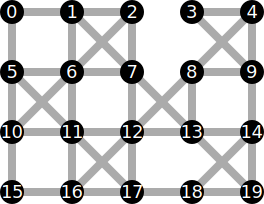

In [3]:
from mindquantum.device.topology import GridQubits

g = GridQubits(4, 5)
te = TopoEditor(g)
te.select([1, 7, 13, 19]).connect_neighbor()
te.select([4, 8, 12, 16]).connect_neighbor()
te.select([5, 11, 17]).connect_neighbor()
te.select([3, 9]).connect_neighbor()
te.select([2, 6, 10]).connect_neighbor()
te.select([14, 18]).connect_neighbor()
te.select([3, 7, 8]).disconnect_all()
te.select([2, 3, 13, 18]).disconnect_all()
draw_topology(g)

In [10]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

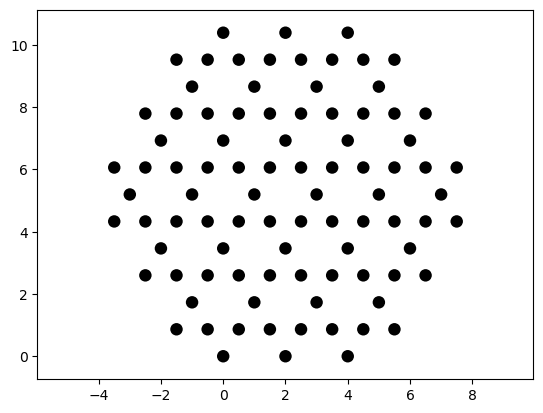

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

topo = kagome.topo

fig, ax = plt.subplots()
for i in topo.all_qubit_id():
    node = topo[i]
    color = node.color
    ax.add_patch(Circle((node.poi_x, node.poi_y), 0.2, facecolor=color))
ax.axis('equal')
plt.show()